In [580]:
import numpy as np
import pandas as pd
import re
import pickle
import lightgbm as lgb
from sklearn.model_selection import cross_validate, KFold
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'IPAGothic'

In [583]:
train = pd.read_csv("../data/train_Youto_sentence_and_heading.csv")

with open("../dump/noun_list.pickle", 'br') as f:
    noun_list = pickle.load(f)

with open("../dump/clue_words.pickle", 'br') as f:
    clue_word_by_BS = pickle.load(f)
    
clue_word_entropy = pd.read_csv("../data/clue_word_of_Sahen-setsuzoku_with_beta=0.1.csv", names=['clue_word']).clue_word.values

In [584]:
# ブートストラップ法で得た手がかり語で学習データをフィルタリング
print("train length :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train = train.loc[train.sentence.str.contains("|".join(clue_word_by_BS))].reset_index(drop=True)
print("train length (filtering) :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train length : 6671
label 1 : 1514 	label 0 : 5157
train length (filtering) : 4386
label 1 : 1206 	label 0 : 3180


In [585]:
# 文中に各手がかり語が含まれているどうかの特徴量を作成

feature_word_dict = {}

for word in np.append(clue_word_entropy, ['用途', '用い', '使わ']):
    feature_word_dict[word] = train.sentence.str.contains(fr'{word}').tolist()

In [586]:
# サブタイトル名をもとにカテゴリ変数を作成する

train = train.assign(heading_cat = np.nan)

cat1 = r'NO_SUBTITLE'
train.loc[train.heading.str.contains(cat1), 'heading_cat'] = 0

cat2 = r'|'.join(np.append(clue_word_entropy, '用途'))
train.loc[train.heading.str.contains(cat2), 'heading_cat'] = 1

train.loc[train.heading_cat.isna(), 'heading_cat'] = 2

In [587]:
# 文中にカテゴリ名が含まれているどうか

category_list = '|'.join(pd.read_csv("../data/category_in_noun_list.csv").category.values)
is_contain_cat = train.sentence.str.contains(category_list).tolist()

In [588]:
train_X = \
pd.DataFrame(feature_word_dict).assign(
    heading_cat = train.heading_cat
    , is_contain_cat = is_contain_cat
)
train_X.heading_cat = train_X.heading_cat.astype('category') 
train_y = train.label.tolist()

In [598]:
model = lgb.LGBMClassifier(is_unbalance=False)

scores = cross_validate(model, train_X, train_y, scoring=['f1', 'precision', 'recall'], cv=5)

print("f1: ", scores['test_f1'].mean())
print("precision: ", scores['test_precision'].mean())
print("recall: ", scores['test_recall'].mean())

f1:  0.6296068156911978
precision:  0.6842778052419431
recall:  0.586197318336134


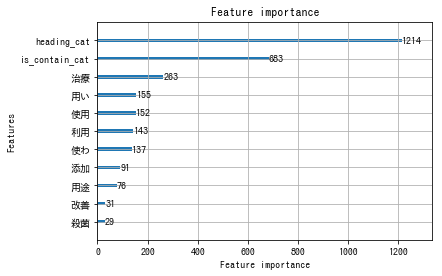

In [599]:
model.fit(train_X, train_y)
lgb.plot_importance(model)

In [600]:
predict = model.predict(train_X)

In [601]:
TP_index = np.where((predict == train_y) & (predict == 1))[0]
TN_index = np.where((predict == train_y) & (predict == 0))[0]
FP_index = np.where((predict != train_y) & (predict == 1))[0]
FN_index = np.where((predict != train_y) & (predict == 0))[0]

In [602]:
print("TP: ", len(TP_index))
print("TN: ", len(TN_index))
print("FP: ", len(FP_index))
print("FN: ", len(FN_index))

TP:  709
TN:  2893
FP:  287
FN:  497


In [604]:
print(train.loc[FN_index, 'sentence'].values)

['イソプロピルアンチピリン（Isopropylantipyrine）、別名、プロピフェナゾン（Propyphenazone）は、アンチピリンの誘導体であり、ピリン系に属する解熱鎮痛薬である。'
 '日本では配合用の原末が医療用に販売されているほか、第2類医薬品として市販の風邪薬に配合されている。'
 'ケトチフェン（Ketotifen）は第二世代の非競合的H1ヒスタミン受容体遮断薬で肥満細胞安定化薬（英語版）である。'
 '抗ヒスタミン作用の他に、ロイコトリエン阻害効果とホスホジエステラーゼ阻害効果を持つ。'
 'L-型カルシウムチャネルを阻害して血管平滑筋の弛緩効果を示す。'
 'ニカルジピン（英語版）とは違い、服用後の効果発現が緩やかで降圧効果が長く続き、心拍数を上昇させない。'
 'またアゼルニジピンは強力な抗酸化物質であり、動物実験では動脈硬化抑制効果を持つ。'
 'オシメルチニブ（Osimertinib、旧名：メレレチニブ、mereletinib）は、第三世代の上皮成長因子受容体（EGFR）チロシンキナーゼ阻害薬（英語版）（TKI）である。'
 'したがって、これらから作られた飲食物、例えば、各種コーヒー飲料、緑茶、ウーロン茶、紅茶、ココアなどの飲料や、チョコレートなどの加工食品にもカフェインは含まれる。'
 '飲食品では主に、コーヒー飲料、緑茶、ウーロン茶、紅茶、ココア、コーラや栄養ドリンクなどの飲料、チョコレートなどにカフェインが含まれる。'
 '総合感冒薬ではカフェインの作用である鎮痛補助目的が主で、配合されたジフェンヒドラミンやクロルフェニラミンなど催眠性の強い抗ヒスタミン剤の副作用を緩和する目的ではない（実際のところ、催眠性成分の緩和には至らない）。'
 'これらはカフェインレスとして知られ、コーヒー、コーラ、茶類などのうち、カフェインの含有量の少ないもしくは含まないものとしては、ノンカフェインコーヒー（デカフェ）、ノンカフェイン紅茶、ノンカフェインコーラ、また杜仲茶や麦茶、黒豆茶、そば茶、甜茶、ゴーヤ茶、昆布茶、柚子茶、ハーブティー、ルイボスティー、たんぽぽコーヒーなどがある。'
 '市販の鎮痛薬に含まれるカフェインや他の成分の依存や離脱症状が薬物乱用頭痛の発症に寄与する。'
 '医療分野において医薬品医療機器等法では1回（1錠・1包等）あた